In [1]:
import math
import numpy as np

from scipy.optimize import brentq
from dps_lake_model import lake_model, get_antropogenic_release


from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging,
                           Constant, Constraint, Policy, IpyparallelEvaluator, perform_experiments,
                           SequentialEvaluator, Scenario)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 
from ema_workbench.analysis import parcoords
import itertools
import copy

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [2]:
#define model
model = Model('dpslake', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                          RealParameter('q', 2.0, 4.5),
                          RealParameter('mean', 0.01, 0.05),
                          RealParameter('stdev', 0.001, 0.005),
                          RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                   RealParameter("c2", -2, 2),
                   RealParameter("r1", 0, 2),
                   RealParameter("r2", 0, 2),
                   RealParameter("w1", 0, 1)]

#model.constantcs = [Constant('alpha', 0.41),
#                         Constant('reps', 150)],

In [3]:
#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#specify constraints which would lead to the worst cases: high max_P, low utility, low reliability (not used)
constraints = [Constraint("low reliability", outcome_names="reliability",
                          function=lambda x:max(0, x-0.25)),
               Constraint("high pollution", outcome_names="max_P",
                          function=lambda x:max(0, 6-x)),
               Constraint("low utility", outcome_names="utility",
                          function=lambda x:max(0, x-0.25))]

In [4]:
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=5)

[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished


In [5]:
experiments

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.186784,0.958115,0.045846,3.732011,0.003225,0.626990,1.743124,0.597109,0.438548,0.806901,0,0,dpslake
1,0.229672,0.942784,0.040132,4.483908,0.002144,0.626990,1.743124,0.597109,0.438548,0.806901,1,0,dpslake
2,0.101446,0.966161,0.030641,2.618251,0.002731,0.626990,1.743124,0.597109,0.438548,0.806901,2,0,dpslake
3,0.386338,0.945756,0.026466,2.020233,0.003215,0.626990,1.743124,0.597109,0.438548,0.806901,3,0,dpslake
4,0.265138,0.988875,0.014864,4.104175,0.001607,0.626990,1.743124,0.597109,0.438548,0.806901,4,0,dpslake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.145706,0.984035,0.023893,3.474851,0.001087,1.974986,-0.026739,1.649086,1.405559,0.225415,995,4,dpslake
4996,0.168441,0.963946,0.025216,3.973997,0.002972,1.974986,-0.026739,1.649086,1.405559,0.225415,996,4,dpslake
4997,0.337756,0.972254,0.019025,3.202904,0.004726,1.974986,-0.026739,1.649086,1.405559,0.225415,997,4,dpslake
4998,0.227355,0.972894,0.017078,3.617948,0.004397,1.974986,-0.026739,1.649086,1.405559,0.225415,998,4,dpslake


In [6]:
outcomes = pd.DataFrame.from_dict(outcomes)
outcomes

,max_P,utility,inertia,reliability
0,6.129649,0.941752,0.99,0.0501
1,4.961374,0.697172,0.99,0.0801
2,11.126118,1.144255,0.99,0.0204
3,2.585299,0.734623,0.99,0.0502
4,4.194698,2.420868,0.99,0.1394
...,...,...,...,...
4995,7.708205,2.004322,0.99,0.0500
4996,6.677811,1.081248,0.99,0.0609
4997,3.247836,1.355197,0.99,0.1288
4998,4.900471,1.381177,0.99,0.0806


<font color='green'>
Here, we select scenarios which lead to the worst cases: high max_P, low utility, low reliability. We left inertia from further consideration because the values it resulted throughout all experiments were not significantly different. Whether low or high is identified by comparing with its 11 percentile, instead of median. That is because after implementing the 'median' selection, we get 897 results of scenario. Considering the large number of scenarios, we would like to narrow it by selecting the scenario based on 11th percentile so that they would more represent worst cases.
</font>

In [7]:
oois = ['max_P', 'reliability', 'utility']
oois

['max_P', 'reliability', 'utility']

In [8]:
#here, the policy-relevant scenarios defined by median thresholds are selected
indices = []
for ooi in oois:
    if ooi in ['max_P']:
        a = outcomes[ooi] > np.percentile(outcomes[ooi], 89)
    else: 
        a = outcomes[ooi] < np.percentile(outcomes[ooi], 11)
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [9]:
newOutcomes

{'max_P': 39       9.174464
 76      11.191285
 736      9.725261
 1039     9.174405
 1076    11.190895
 1736     9.724906
 2039     9.175071
 2076    11.190844
 2736     9.725112
 3039     9.173959
 3076    11.189993
 3736     9.724472
 4039     9.173693
 4076    11.191089
 4736     9.725739
 Name: max_P, dtype: float64,
 'reliability': 39      0.0200
 76      0.0100
 736     0.0199
 1039    0.0200
 1076    0.0100
 1736    0.0200
 2039    0.0200
 2076    0.0100
 2736    0.0200
 3039    0.0200
 3076    0.0100
 3736    0.0200
 4039    0.0200
 4076    0.0100
 4736    0.0200
 Name: reliability, dtype: float64,
 'utility': 39      0.594098
 76      0.584683
 736     0.613737
 1039    0.594098
 1076    0.584683
 1736    0.613737
 2039    0.594098
 2076    0.584683
 2736    0.613737
 3039    0.594098
 3076    0.584683
 3736    0.613737
 4039    0.594098
 4076    0.584683
 4736    0.613737
 Name: utility, dtype: float64}

In [10]:
newOutcomes = pd.DataFrame.from_dict(newOutcomes)
selectedcases = newOutcomes.head(4)
selected = list(selectedcases.index)
selected

[39, 76, 736, 1039]

In [11]:
sel_col = ["unselected cases" for x in range (5000)]
count = 0
for i in enumerate(sel_col):
    if count in selected:
        sel_col[count] = "worst cases selected"
    count +=1

In [12]:
data = copy.copy(outcomes)
data['scenarios'] = sel_col
data

,max_P,utility,inertia,reliability,scenarios
0,6.129649,0.941752,0.99,0.0501,unselected cases
1,4.961374,0.697172,0.99,0.0801,unselected cases
2,11.126118,1.144255,0.99,0.0204,unselected cases
3,2.585299,0.734623,0.99,0.0502,unselected cases
4,4.194698,2.420868,0.99,0.1394,unselected cases
...,...,...,...,...,...
4995,7.708205,2.004322,0.99,0.0500,unselected cases
4996,6.677811,1.081248,0.99,0.0609,unselected cases
4997,3.247836,1.355197,0.99,0.1288,unselected cases
4998,4.900471,1.381177,0.99,0.0806,unselected cases


C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


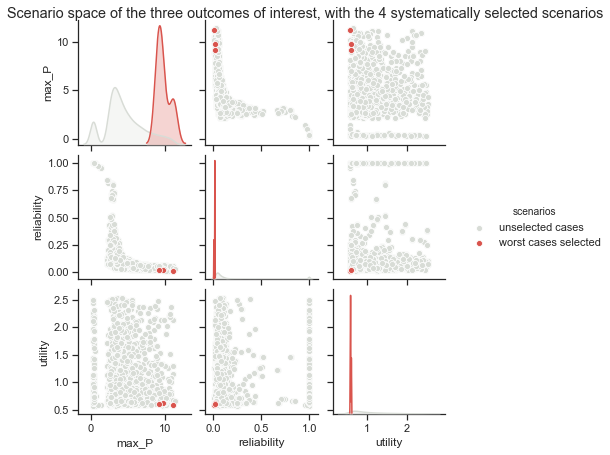

In [13]:
sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["light grey", "pale red"]

#for entry, name in zip(np.unique(sel_column), ['any', 'policy relevant','prim', 'diversity_selected', 'random_selected']):
#    data.replace(entry, name, inplace=True)

g = sns.pairplot(data, hue='scenarios', size=2, palette=sns.xkcd_palette(colors), vars=oois)

plt.suptitle("Scenario space of the three outcomes of interest, with the 4 systematically selected scenarios", y=1.02)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

#g.savefig('./figs/mordm/scatter_diverse_random_prim.png', dpi=600)
plt.show()

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


<font color='green'>Here are the scenarios selected:</font>

In [14]:
wc = experiments.iloc[selected]
wc

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
39,0.123777,0.932735,0.043555,2.171914,0.003919,0.626990,1.743124,0.597109,0.438548,0.806901,39,0,dpslake
76,0.100665,0.931644,0.033297,2.067038,0.001683,0.626990,1.743124,0.597109,0.438548,0.806901,76,0,dpslake
736,0.115464,0.934903,0.031008,2.113338,0.003499,0.626990,1.743124,0.597109,0.438548,0.806901,736,0,dpslake
1039,0.123777,0.932735,0.043555,2.171914,0.003919,-1.137201,-0.461442,1.348067,1.995791,0.620569,39,1,dpslake


In [15]:
outcomes

,max_P,utility,inertia,reliability
0,6.129649,0.941752,0.99,0.0501
1,4.961374,0.697172,0.99,0.0801
2,11.126118,1.144255,0.99,0.0204
3,2.585299,0.734623,0.99,0.0502
4,4.194698,2.420868,0.99,0.1394
...,...,...,...,...
4995,7.708205,2.004322,0.99,0.0500
4996,6.677811,1.081248,0.99,0.0609
4997,3.247836,1.355197,0.99,0.1288
4998,4.900471,1.381177,0.99,0.0806


In [17]:
worstcases = []
for i in range(len(wc)):
    b = wc.iloc[i,0]
    delta = wc.iloc[i,1]
    mean = wc.iloc[i,2]
    q = wc.iloc[i,3]
    stdev = wc.iloc[i,4]
    worstcases.append(Scenario(f"Scenario{i}",**{"b": b, "delta": delta, "mean": mean, "q": q, "stdev": stdev}))
worstcases

[Scenario({'b': 0.12377677569910278, 'delta': 0.9327347481673633, 'mean': 0.04355454551455187, 'q': 2.171913853344855, 'stdev': 0.003919290137966085}),
 Scenario({'b': 0.10066478675043682, 'delta': 0.9316444471144961, 'mean': 0.03329689484401522, 'q': 2.0670379953949922, 'stdev': 0.0016825469627014095}),
 Scenario({'b': 0.11546365217059881, 'delta': 0.9349032444060393, 'mean': 0.03100794212322963, 'q': 2.1133376524017677, 'stdev': 0.00349940187336448}),
 Scenario({'b': 0.12377677569910278, 'delta': 0.9327347481673633, 'mean': 0.04355454551455187, 'q': 2.171913853344855, 'stdev': 0.003919290137966085})]

<font color='green'>Here, we refer the experiment to scenario name as below:
- 1st experiment as *Scenario0*
- 2nd experiment as *Scenario1*
- 3rd experiment as *Scenario2*
- 4th experiment as *Scenario3*
</font>

In [18]:
#specify outcomes for worstcases 
# as we want to examine the worst cases, we need to change the outcomes' kind so the direction is undesirable

model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,15)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#specify constraints which would lead to the worst cases: high max_P, low utility, low reliability
#they are set in accordance with the criteria of the selected scenarios
constraints = [Constraint("low reliability", outcome_names="reliability",
                          function=lambda x:max(0, x-np.percentile(outcomes['reliability'], 11))), #89 percentile
               Constraint("high pollution", outcome_names="max_P",
                          function=lambda x:max(0, np.percentile(outcomes['max_P'], 89)-x)), #11 percentile
               Constraint("low utility", outcome_names="utility",
                          function=lambda x:max(0, x-np.percentile(outcomes['utility'], 11)))] #11 percentile

### Many-Objective Optimization for Scenario0

In [19]:
with MultiprocessingEvaluator(model) as evaluator:
    results0, convergence0 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.03, 0.002, 0.002, 0.002],
                                    reference=worstcases[0],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 495/10000 nfe
[MainProcess/INFO] generation 10: 988/10000 nfe
[MainProcess/INFO] generation 15: 1481/10000 nfe
[MainProcess/INFO] generation 20: 1977/10000 nfe
[MainProcess/INFO] generation 25: 2470/10000 nfe
[MainProcess/INFO] generation 30: 2967/10000 nfe
[MainProcess/INFO] generation 35: 3463/10000 nfe
[MainProcess/INFO] generation 40: 3956/10000 nfe
[MainProcess/INFO] generation 45: 4449/10000 nfe
[MainProcess/INFO] generation 50: 4945/10000 nfe
[MainProcess/INFO] generation 55: 5444/10000 nfe
[MainProcess/INFO] generation 60: 5943/10000 nfe
[MainProcess/INFO] generation 65: 6438/10000 nfe
[MainProcess/INFO] generation 70: 6933/10000 nfe
[MainProcess/INFO] generation 75: 7424/10000 nfe
[MainProcess/INFO] generation 80: 7919/10000 nfe
[MainProcess/INFO] generation 85: 8414/10000 nfe
[MainProcess/INFO] generation 90: 8910/10000 nfe
[MainProcess/INFO] generation 95: 9401/10000

In [20]:
results0

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.678923,0.522908,1.757221,1.931089,0.659849,9.174219,0.373442,0.9718,0.0299
1,0.585535,0.704372,1.975370,1.747827,0.551249,9.174929,0.371235,0.9753,0.0299
2,0.718235,0.724703,1.962324,1.965494,0.007527,9.173332,0.377736,0.9735,0.0279
3,0.732659,0.766349,1.986308,1.965120,0.848405,9.176036,0.379790,0.9719,0.0270
4,0.695993,0.615162,1.929298,1.989856,0.681515,9.173365,0.367618,0.9792,0.0299
5,0.902159,0.753637,1.894704,1.987744,0.119705,9.174154,0.393821,0.9722,0.0200
6,0.774165,0.749853,1.897429,1.960145,0.068847,9.175512,0.387254,0.9705,0.0217
7,0.812229,0.750512,1.895988,1.991068,0.039438,9.175204,0.383720,0.9707,0.0239
8,0.722404,0.751114,1.883034,1.996807,0.007527,9.175258,0.381821,0.9713,0.0259
9,0.809187,0.607485,1.883034,1.988222,0.004839,9.174790,0.348491,0.9715,0.0300


In [21]:
convergence0

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.010769,9,100
2,0.011289,60,1183
3,0.011253,105,2271
4,0.011475,123,3364
5,0.011475,129,4449
6,0.011449,139,5544
7,0.011449,142,6637
8,0.011560,145,7720
9,0.011486,149,8811


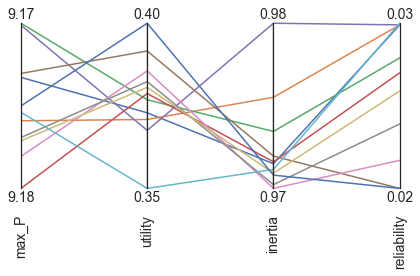

In [22]:
outcomes0 = results0.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits0 = parcoords.get_limits(outcomes0)
axes0 = parcoords.ParallelAxes(limits0)
axes0.plot(outcomes0)

# we invert this axis so direction of desirability is the same 
axes0.invert_axis('max_P') 
plt.show()

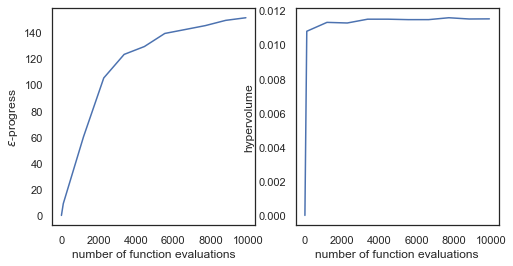

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence0.nfe, convergence0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence0.nfe, convergence0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario1

In [24]:
with MultiprocessingEvaluator(model) as evaluator:
    results1, convergence1 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.03, 0.002, 0.002, 0.002],
                                    reference=worstcases[1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 10: 987/10000 nfe
[MainProcess/INFO] generation 15: 1485/10000 nfe
[MainProcess/INFO] generation 20: 1974/10000 nfe
[MainProcess/INFO] generation 25: 2464/10000 nfe
[MainProcess/INFO] generation 30: 2960/10000 nfe
[MainProcess/INFO] generation 35: 3455/10000 nfe
[MainProcess/INFO] generation 40: 3948/10000 nfe
[MainProcess/INFO] generation 45: 4445/10000 nfe
[MainProcess/INFO] generation 50: 4935/10000 nfe
[MainProcess/INFO] generation 55: 5431/10000 nfe
[MainProcess/INFO] generation 60: 5927/10000 nfe
[MainProcess/INFO] generation 65: 6424/10000 nfe
[MainProcess/INFO] generation 70: 6916/10000 nfe
[MainProcess/INFO] generation 75: 7411/10000 nfe
[MainProcess/INFO] generation 80: 7905/10000 nfe
[MainProcess/INFO] generation 85: 8403/10000 nfe
[MainProcess/INFO] generation 90: 8903/10000 nfe
[MainProcess/INFO] generation 95: 9397/10000

In [25]:
results1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.761142,0.828381,1.832287,1.900066,0.003633,11.190925,0.413904,0.9707,0.0178
1,0.412595,0.300976,1.959082,1.238429,0.868649,11.190769,0.323565,0.9716,0.0300
2,0.761142,0.828295,1.800926,1.875651,0.008072,11.190984,0.417565,0.9700,0.0120
3,0.639072,0.434658,1.863581,1.995827,0.006929,11.191039,0.319237,0.9790,0.0300
4,0.797522,0.631559,1.876678,1.996341,0.016965,11.190604,0.343579,0.9700,0.0220
5,0.591451,0.508310,1.958489,1.990371,0.966229,11.190627,0.335551,0.9711,0.0299
6,0.609191,0.497481,1.880396,1.107945,0.053146,11.190224,0.417830,0.9795,0.0100
7,0.761142,0.828381,1.540544,1.887574,0.004925,11.189853,0.415953,0.9700,0.0129
8,1.008864,0.624854,1.978156,1.995991,0.006009,11.190469,0.341736,0.9700,0.0258
9,0.666855,0.872611,1.181691,1.964590,0.001596,11.190933,0.419838,0.9700,0.0100


In [26]:
convergence1

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.012850,12,100
2,0.014923,75,1185
3,0.014969,112,2267
4,0.014969,136,3355
5,0.014970,155,4445
6,0.015010,162,5529
7,0.015010,165,6621
8,0.015010,169,7707
9,0.015012,172,8803


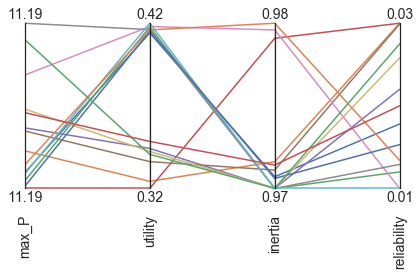

In [27]:
outcomes1 = results1.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits1 = parcoords.get_limits(outcomes1)
axes1 = parcoords.ParallelAxes(limits1)
axes1.plot(outcomes1)

# we invert this axis so direction of desirability is the same 
axes1.invert_axis('max_P') 
plt.show()

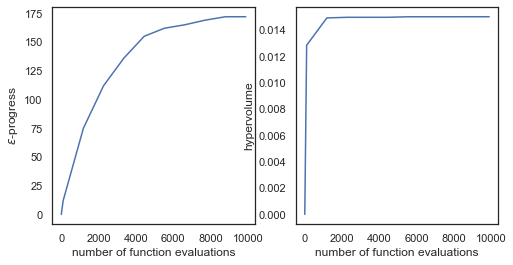

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence1.nfe, convergence1.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence1.nfe, convergence1.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario2

In [29]:
with MultiprocessingEvaluator(model) as evaluator:
    results2, convergence2 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.03, 0.002, 0.002, 0.002],
                                    reference=worstcases[2],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 994/10000 nfe
[MainProcess/INFO] generation 15: 1492/10000 nfe
[MainProcess/INFO] generation 20: 1986/10000 nfe
[MainProcess/INFO] generation 25: 2482/10000 nfe
[MainProcess/INFO] generation 30: 2977/10000 nfe
[MainProcess/INFO] generation 35: 3475/10000 nfe
[MainProcess/INFO] generation 40: 3971/10000 nfe
[MainProcess/INFO] generation 45: 4469/10000 nfe
[MainProcess/INFO] generation 50: 4965/10000 nfe
[MainProcess/INFO] generation 55: 5456/10000 nfe
[MainProcess/INFO] generation 60: 5948/10000 nfe
[MainProcess/INFO] generation 65: 6445/10000 nfe
[MainProcess/INFO] generation 70: 6940/10000 nfe
[MainProcess/INFO] generation 75: 7436/10000 nfe
[MainProcess/INFO] generation 80: 7935/10000 nfe
[MainProcess/INFO] generation 85: 8431/10000 nfe
[MainProcess/INFO] generation 90: 8926/10000 nfe
[MainProcess/INFO] generation 95: 9422/10000

In [30]:
results2

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.727280,0.561021,1.983281,1.813871,0.765296,9.726786,0.377383,0.9719,0.0299
1,0.367724,0.578391,1.980750,1.410013,0.169547,9.726171,0.399658,0.9717,0.0205
2,0.681050,0.564687,1.676989,1.726007,0.765735,9.726008,0.400802,0.9770,0.0200
3,0.627466,0.401425,1.993454,1.334765,0.995710,9.725078,0.352492,0.9716,0.0300
4,0.730598,0.537792,1.988034,1.138468,0.795092,9.727065,0.405572,0.9705,0.0200
5,0.618932,0.368884,1.565335,1.902395,0.996354,9.725394,0.402717,0.9724,0.0200
6,0.730702,0.775617,1.985520,1.965615,0.788061,9.727009,0.389916,0.9736,0.0239
7,0.680549,0.221957,1.916050,1.825491,0.868067,9.725430,0.371893,0.9731,0.0299
8,0.728562,0.960550,1.996136,1.740250,0.978067,9.726548,0.387943,0.9719,0.0251
9,0.726646,0.827375,1.996171,1.893335,0.977908,9.725833,0.383637,0.9707,0.0279


In [31]:
convergence2

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.011168,4,100
2,0.011878,37,1192
3,0.012107,80,2282
4,0.012103,91,3376
5,0.012104,98,4469
6,0.012104,99,5556
7,0.012104,100,6642
8,0.012109,101,7735
9,0.012107,104,8826


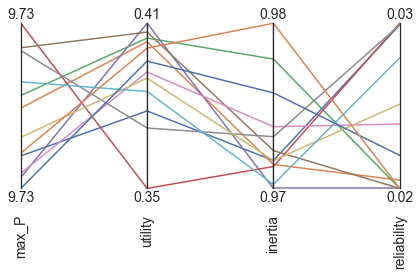

In [32]:
outcomes2 = results2.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits2 = parcoords.get_limits(outcomes2)
axes2 = parcoords.ParallelAxes(limits2)
axes2.plot(outcomes2)

# we invert this axis so direction of desirability is the same 
axes2.invert_axis('max_P') 
plt.show()

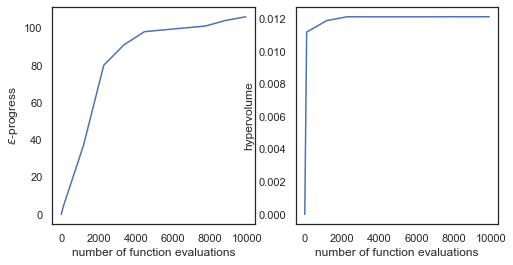

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence2.nfe, convergence2.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence2.nfe, convergence2.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario3

In [34]:
with MultiprocessingEvaluator(model) as evaluator:
    results3, convergence3 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.03, 0.002, 0.002, 0.002],
                                    reference=worstcases[3],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 994/10000 nfe
[MainProcess/INFO] generation 15: 1491/10000 nfe
[MainProcess/INFO] generation 20: 1986/10000 nfe
[MainProcess/INFO] generation 25: 2483/10000 nfe
[MainProcess/INFO] generation 30: 2980/10000 nfe
[MainProcess/INFO] generation 35: 3470/10000 nfe
[MainProcess/INFO] generation 40: 3967/10000 nfe
[MainProcess/INFO] generation 45: 4463/10000 nfe
[MainProcess/INFO] generation 50: 4957/10000 nfe
[MainProcess/INFO] generation 55: 5453/10000 nfe
[MainProcess/INFO] generation 60: 5946/10000 nfe
[MainProcess/INFO] generation 65: 6440/10000 nfe
[MainProcess/INFO] generation 70: 6934/10000 nfe
[MainProcess/INFO] generation 75: 7428/10000 nfe
[MainProcess/INFO] generation 80: 7925/10000 nfe
[MainProcess/INFO] generation 85: 8419/10000 nfe
[MainProcess/INFO] generation 90: 8915/10000 nfe
[MainProcess/INFO] generation 95: 9412/10000

In [35]:
results3

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.760582,1.154710,1.983358,1.548653,0.988653,9.174515,0.393230,0.9716,0.0200
1,0.653919,0.627120,1.825165,1.482982,0.962779,9.174510,0.374957,0.9718,0.0298
2,-0.174467,-0.279455,1.769909,0.991033,0.423680,9.174697,0.505945,0.9699,0.0300
3,0.769737,0.428672,1.988401,1.762269,0.983749,9.176977,0.387939,0.9705,0.0218
4,0.668711,0.401253,1.897467,1.730270,0.976492,9.173937,0.369728,0.9772,0.0299
5,0.734113,0.841980,1.986764,1.797919,0.956393,9.174132,0.381346,0.9711,0.0253
6,0.679900,0.421512,1.897573,1.762269,0.963624,9.174347,0.371988,0.9754,0.0299
7,-0.153369,-0.163720,0.663979,1.036629,0.994394,9.176070,0.529496,0.9679,0.0300
8,0.733941,0.653202,1.995617,1.483134,0.962788,9.175387,0.379066,0.9719,0.0278
9,0.618598,0.390819,1.996365,1.832732,0.980563,9.175642,0.348984,0.9717,0.0300


In [36]:
convergence3

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.010275,8,100
2,0.011473,46,1193
3,0.012204,81,2286
4,0.012272,94,3370
5,0.012306,99,4463
6,0.012255,100,5553
7,0.012262,101,6637
8,0.012232,103,7726
9,0.012232,105,8816


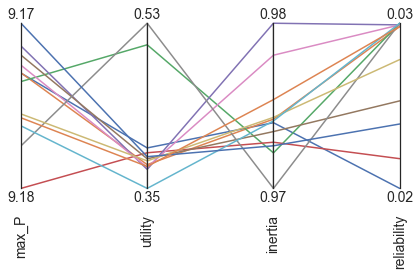

In [37]:
outcomes3 = results3.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits3 = parcoords.get_limits(outcomes3)
axes3 = parcoords.ParallelAxes(limits3)
axes3.plot(outcomes3)

# we invert this axis so direction of desirability is the same 
axes3.invert_axis('max_P') 
plt.show()

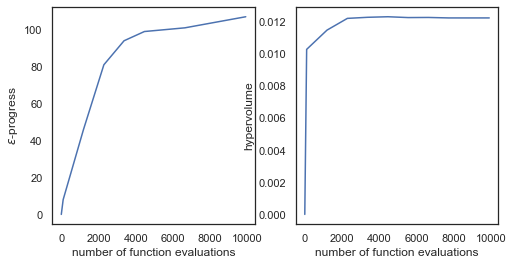

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence3.nfe, convergence3.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence3.nfe, convergence3.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


<font color='green'>For re-evaluation under deep uncertainty, we would select from each scenario 6 policies which consist of:
1. A policy resulting in max max_P
2. A policy resulting in min max_P
3. A policy resulting in max reliability
4. A policy resulting in min reliability
5. A policy resulting in max utility
6. A policy resulting in min utility

However, there is a possibility that the same policy results in max max_P and max utility and so on. Therefore, the total number of policies selected may be less than 24. </font>

In [39]:
#selecting policies from Scenario0
sel_idx_0 = [results0['max_P'].argmax(), results0['reliability'].argmax(),
             results0['utility'].argmax(), results0['max_P'].argmin(),
             results0['reliability'].argmin(), results0['utility'].argmin()]
sel_idx_0

[3, 9, 10, 2, 5, 9]

In [40]:
sel_idx_0 = list(set(sel_idx_0)) #select only unique indexes
sel_pol_0 = results0.iloc[sel_idx_0]
sel_pol_0

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
2,0.718235,0.724703,1.962324,1.965494,0.007527,9.173332,0.377736,0.9735,0.0279
3,0.732659,0.766349,1.986308,1.965120,0.848405,9.176036,0.379790,0.9719,0.0270
5,0.902159,0.753637,1.894704,1.987744,0.119705,9.174154,0.393821,0.9722,0.0200
9,0.809187,0.607485,1.883034,1.988222,0.004839,9.174790,0.348491,0.9715,0.0300
10,0.372490,0.563184,1.365810,1.381022,0.011427,9.174687,0.402983,0.9712,0.0200


In [41]:
#selecting policies from Scenario1
sel_idx_1 = [results1['max_P'].argmax(), results1['reliability'].argmax(),
             results1['utility'].argmax(), results1['max_P'].argmin(),
             results1['reliability'].argmin(), results1['utility'].argmin()]
sel_idx_1

[3, 1, 9, 7, 6, 3]

In [42]:
sel_idx_1 = list(set(sel_idx_1)) #select only unique indexes
sel_pol_1 = results1.iloc[sel_idx_1]
sel_pol_1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
1,0.412595,0.300976,1.959082,1.238429,0.868649,11.190769,0.323565,0.9716,0.0300
3,0.639072,0.434658,1.863581,1.995827,0.006929,11.191039,0.319237,0.9790,0.0300
6,0.609191,0.497481,1.880396,1.107945,0.053146,11.190224,0.417830,0.9795,0.0100
7,0.761142,0.828381,1.540544,1.887574,0.004925,11.189853,0.415953,0.9700,0.0129
9,0.666855,0.872611,1.181691,1.964590,0.001596,11.190933,0.419838,0.9700,0.0100


In [43]:
#selecting policies from Scenario2
sel_idx_2 = [results2['max_P'].argmax(), results2['reliability'].argmax(),
             results2['utility'].argmax(), results2['max_P'].argmin(),
             results2['reliability'].argmin(), results2['utility'].argmin()]
sel_idx_2

[10, 3, 4, 3, 2, 3]

In [44]:
sel_idx_2 = list(set(sel_idx_2)) #select only unique indexes
sel_pol_2 = results2.iloc[sel_idx_2]
sel_pol_2

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
2,0.681050,0.564687,1.676989,1.726007,0.765735,9.726008,0.400802,0.9770,0.020
10,0.758333,0.545561,1.998090,1.845406,0.987837,9.727205,0.393399,0.9753,0.022
3,0.627466,0.401425,1.993454,1.334765,0.995710,9.725078,0.352492,0.9716,0.030
4,0.730598,0.537792,1.988034,1.138468,0.795092,9.727065,0.405572,0.9705,0.020


In [45]:
#selecting policies from Scenario3
sel_idx_3 = [results3['max_P'].argmax(), results3['reliability'].argmax(),
             results3['utility'].argmax(), results3['max_P'].argmin(),
             results3['reliability'].argmin(), results3['utility'].argmin()]
sel_idx_3

[3, 2, 7, 10, 0, 9]

In [46]:
sel_idx_3 = list(set(sel_idx_3)) #select only unique indexes
sel_pol_3 = results3.iloc[sel_idx_3]
sel_pol_3

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.760582,1.154710,1.983358,1.548653,0.988653,9.174515,0.393230,0.9716,0.0200
2,-0.174467,-0.279455,1.769909,0.991033,0.423680,9.174697,0.505945,0.9699,0.0300
3,0.769737,0.428672,1.988401,1.762269,0.983749,9.176977,0.387939,0.9705,0.0218
7,-0.153369,-0.163720,0.663979,1.036629,0.994394,9.176070,0.529496,0.9679,0.0300
9,0.618598,0.390819,1.996365,1.832732,0.980563,9.175642,0.348984,0.9717,0.0300
10,0.754961,0.290076,1.989416,1.735603,0.992548,9.173452,0.383657,0.9703,0.0239


In [47]:
#concatenating all selected policies
sel_pols = pd.concat([sel_pol_0, sel_pol_1, sel_pol_2, sel_pol_3], axis=0, ignore_index=True)
sel_pols = sel_pols.loc[:,['c1','c2','r1','r2','w1']]
sel_pols

,c1,c2,r1,r2,w1
0,0.718235,0.724703,1.962324,1.965494,0.007527
1,0.732659,0.766349,1.986308,1.965120,0.848405
2,0.902159,0.753637,1.894704,1.987744,0.119705
3,0.809187,0.607485,1.883034,1.988222,0.004839
4,0.372490,0.563184,1.365810,1.381022,0.011427
5,0.412595,0.300976,1.959082,1.238429,0.868649
6,0.639072,0.434658,1.863581,1.995827,0.006929
7,0.609191,0.497481,1.880396,1.107945,0.053146
8,0.761142,0.828381,1.540544,1.887574,0.004925
9,0.666855,0.872611,1.181691,1.964590,0.001596


In [54]:
policies = []
for i in range(len(sel_pols)):
    c1 = sel_pols.iloc[i,0]
    c2 = sel_pols.iloc[i,1]
    r1 = sel_pols.iloc[i,2]
    r2 = sel_pols.iloc[i,3]
    w1 = sel_pols.iloc[i,4]
    policies.append(Policy(f"{i}",**{"c1": c1, "c2": c2, "r1": r1, "r2": r2, "w1": w1}))
policies

[Policy({'c1': 0.7182347556240799, 'c2': 0.7247030047183476, 'r1': 1.962323658742952, 'r2': 1.9654944208009875, 'w1': 0.007526788357776953}),
 Policy({'c1': 0.7326588741028627, 'c2': 0.7663492346582244, 'r1': 1.9863075860705652, 'r2': 1.965120387860138, 'w1': 0.8484048809139495}),
 Policy({'c1': 0.9021587731505002, 'c2': 0.7536365458716391, 'r1': 1.8947044229409846, 'r2': 1.9877439448875684, 'w1': 0.11970528588239293}),
 Policy({'c1': 0.8091874297693405, 'c2': 0.6074845831418297, 'r1': 1.8830338741019972, 'r2': 1.988222268516038, 'w1': 0.004839263870288296}),
 Policy({'c1': 0.3724896158442053, 'c2': 0.563183869782723, 'r1': 1.365809770150571, 'r2': 1.381022181942614, 'w1': 0.011427084467878462}),
 Policy({'c1': 0.41259535856812896, 'c2': 0.3009756740596955, 'r1': 1.959081549524744, 'r2': 1.2384291059263848, 'w1': 0.8686490287809305}),
 Policy({'c1': 0.6390716748003057, 'c2': 0.43465795386657247, 'r1': 1.86358136020944, 'r2': 1.9958273604504964, 'w1': 0.0069290366400726056}),
 Policy({'

In [49]:
with MultiprocessingEvaluator(model) as evaluator:
    polresults = perform_experiments(model, 1000, policies, evaluator=evaluator)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 20 policies * 1 model(s) = 20000 experiments
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 14000 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [50]:
polexperiments, poloutcomes = polresults

In [51]:
poloutcomes=pd.DataFrame(poloutcomes)

In [55]:
poloutcomes['policies']=polexperiments['policy']

In [97]:
poloutcomes

,max_P,utility,inertia,reliability,policies
0,0.222057,0.430574,0.9900,1.0000,0
1,0.143120,0.196896,0.9900,1.0000,0
2,0.191699,0.172575,0.9900,1.0000,0
3,0.213526,0.187412,0.9900,1.0000,0
4,0.208764,0.175345,0.9900,1.0000,0
...,...,...,...,...,...
19995,3.966395,1.129463,0.9728,0.1287,19
19996,0.154940,0.300842,0.9900,1.0000,19
19997,3.285629,0.323013,0.9714,0.4021,19
19998,0.151280,0.313721,0.9900,1.0000,19


C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


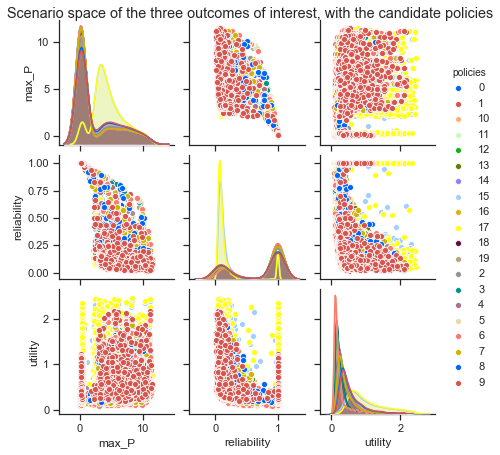

In [57]:
sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["bright blue", "pale red", "peach", "pale green", 
          "green", "olive green", "periwinkle", "baby blue", 
          "gold", "yellow", "plum", "taupe", "grey",
          "teal", "mauve", "beige", "salmon", "mustard"]

gpol = sns.pairplot(poloutcomes, hue='policies', size=2, palette=sns.xkcd_palette(colors), vars=oois)

plt.suptitle("Scenario space of the three outcomes of interest, with the candidate policies", y=1.02)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

#g.savefig('./figs/mordm/scatter_diverse_random_prim.png', dpi=600)
plt.show()

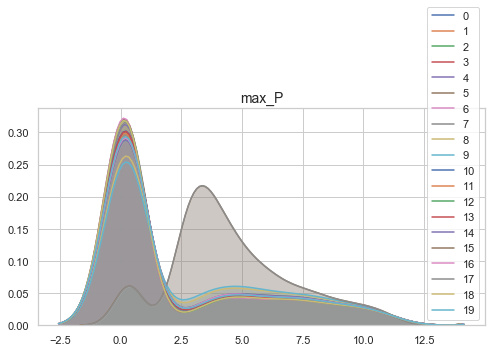

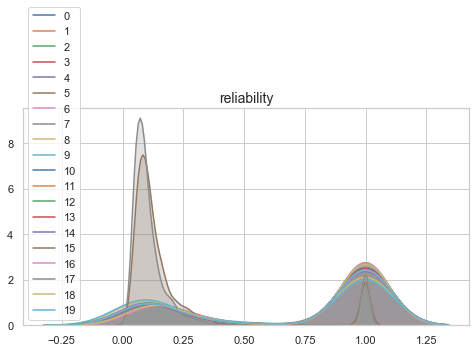

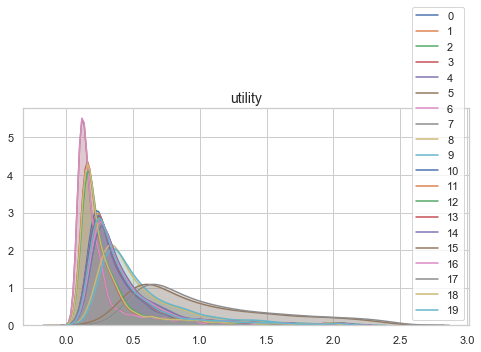

In [95]:
fig, axmaxP = plt.subplots(figsize=(8,4))
fig, axrel = plt.subplots(figsize=(8,4))
fig, axutil = plt.subplots(figsize=(8,4))
axmaxP.set_title('max_P', size=14)
axrel.set_title('reliability', size=14)
axutil.set_title('utility', size=14)

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'max_P'], 
                ax=axmaxP, shade=True, Label=policy)  

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'reliability'], 
                ax=axrel, shade=True, Label=policy)  

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'utility'], 
                ax=axutil, shade=True, Label=policy)  

plt.show()

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

Visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


<font color='green'>The domain criterion provided in Bartholomew and Kwakkel (2020) was for best-cases scenarios policies. While here, our aim is to observe the related policies that may lead to worst cases. Therefore, we need to inverse the domain criterion as follows.
- Utility: 0.25
- Reliability: 0.2
- Inertia: 0.01
</font>

In [98]:
import functools

percentile25 = functools.partial(np.percentile, q=25)
percentile20 = functools.partial(np.percentile, q=20)
percentile1 = functools.partial(np.percentile, q=1)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustness_functions = [ScalarOutcome('20th percentile reliability', kind=MINIMIZE,
                             variable_name='reliability', function=percentile20),
                        ScalarOutcome('1th percentile inertia', kind=MINIMIZE,
                             variable_name='inertia', function=percentile1),
                        ScalarOutcome('25th percentile utility', kind=MINIMIZE,
                             variable_name='utility', function=percentile25)]

In [99]:
nfe = 5000
with MultiprocessingEvaluator(model) as evaluator:
    robust_results = evaluator.robust_optimize(robustness_functions, worstcases,
                            nfe=nfe, epsilons=[0.03, 0.002, 0.002, 0.002])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 498/5000 nfe
[MainProcess/INFO] generation 10: 989/5000 nfe
[MainProcess/INFO] generation 15: 1486/5000 nfe
[MainProcess/INFO] generation 20: 1979/5000 nfe
[MainProcess/INFO] generation 25: 2470/5000 nfe
[MainProcess/INFO] generation 30: 2961/5000 nfe
[MainProcess/INFO] generation 35: 3458/5000 nfe
[MainProcess/INFO] generation 40: 3955/5000 nfe
[MainProcess/INFO] generation 45: 4452/5000 nfe
[MainProcess/INFO] generation 50: 4945/5000 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


In [100]:
robust_results

,c1,c2,r1,r2,w1,20th percentile reliability,1th percentile inertia,25th percentile utility
0,-0.618860,-0.167359,1.938345,0.733855,0.268611,0.02984,0.969803,0.525506
1,0.416292,0.392610,1.932279,1.973971,0.990896,0.03594,0.971215,0.325863
2,0.433688,-0.133762,1.999115,1.772517,0.999995,0.03604,0.972900,0.323978
3,-0.285296,-0.160224,1.959934,0.673406,0.196382,0.03000,0.969803,0.519154
4,0.616607,-0.142020,1.999874,1.940388,0.999995,0.02960,0.970236,0.345950


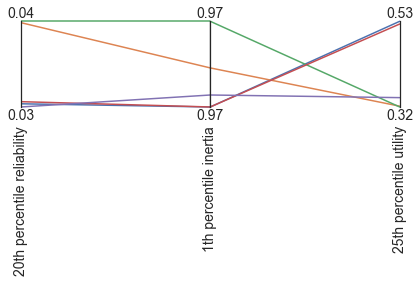

In [110]:
roboutcomes = robust_results.loc[:, ['20th percentile reliability','1th percentile inertia','25th percentile utility']]

roblimits = parcoords.get_limits(roboutcomes)
robaxes = parcoords.ParallelAxes(roblimits)
robaxes.plot(roboutcomes)

plt.show()

In [101]:
def calculate_maxregret(data, obj, n_sol):
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(n_sol)]
    max_regrets = np.max(regrets, axis=1)
    return max_regrets


In [102]:
#[outcome.kind for outcome in outcomes]
ooi_obj ={ooi.name: ooi.kind for ooi in model.outcomes}
print(ooi_obj)

{'max_P': 1, 'utility': -1, 'inertia': -1, 'reliability': -1}


In [104]:
n_sol = len(policies)
n_sol

20

In [109]:
#for ooi, obj in ooi_obj.items():
#    for pol in range(n_sol):
#        rob = calculate_maxregret(poloutcomes[ooi][poloutcomes['policies']==str(pol)], obj, n_sol)
#rob
calculate_maxregret(poloutcomes['max_P'][poloutcomes['policies']=='1'], 1, n_sol)

AxisError: axis 1 is out of bounds for array of dimension 1